# Double Descent with Random Fourier Features

In this section, we will demonstrate the double descent phenomenon when performing regression with Random Fourier Features (RFF).  Given a dataset $\{(x^{(i)}, y^{(i)})\}_{i=1}^{n} \subset \mathbb{R}^{d} \times \mathbb{R}$, we wish to learn a map from $x^{(i)} \to y^{(i)}$.  In order to learn this map, we will first transform the features $x^{(i)}$ via the following \textbf{feature map}: 

\begin{align*}
    \phi_k(x) = \frac{1}{\sqrt{k}} \begin{bmatrix} e^{i \langle v_1, x \rangle}\\
                                                 e^{i \langle v_2, x \rangle} \\
                                                 \vdots \\
                                                 e^{i \langle v_k, x \rangle}
                                                 \end{bmatrix}~~;
\end{align*}
where $v_j \sim \mathcal{N}(\mathbf{0}, I_{d \times d})$ for $j = 1, 2, \ldots, k$.  It is important to note that $\phi_k(x) \in \mathbb{C}^{k}$ and that the inner product in this space is given by: 
\begin{align*}
    \langle u, v \rangle = \sum_{i=1}^{k} u_k \bar{v}_k
\end{align*}
where $\bar{v}_k$ is the complex conjugate of $v_k$.  Given the map $\phi_k: \mathbb{R}^{d} \to \mathbb{C}^{k}$, we now use linear regression to map from $\phi_k(x^{(i)}) \to y^{(i)}$.  In particular, we use gradient descent to minimize the following loss: 
\begin{align}
    \mathcal{L}(w) = \sum_{i=1}^{n} ( y^{(i)} - w^T \phi_k(x^{(i)}))^2 
\end{align}

### Connection to Neural Networks

From the form of the loss function above, we see that the RFF model above is equivalent to a neural network with 1 hidden layer with $k$ hidden units and an elementwise activation function, $\psi: \mathbb{R} \to \mathbb{C}$, with $\psi(\xi) = \frac{1}{\sqrt{k}} e^{i \xi}$.


## Double Descent with Increasing Width
We next show that increasing $k$ (e.g. the width of the 1 hidden layer network above) empirically leads to double descent.  

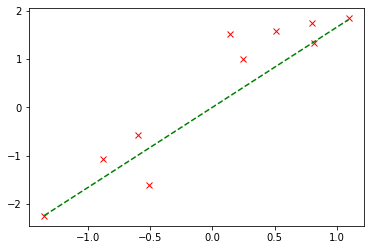

In [24]:
import dataloader as dl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

SEED = 2134

np.random.seed(SEED)
# Dataset for regression
X, y, X_test, y_test, w = dl.make_dataset(n=10, d=1, eps=0.5)

# Visualize Dataset (red) and True Solution (green)
plt.plot(X[0], y[0], 'rx')
plt.plot(X_test[0], y_test[0], 'g--')
plt.show()


### Code for RFF Regression with Finite Number of Features

1 1.9013119603246775 2056.558210257892
5 0.17278681076158883 2056.558210257892
10 1.3858351510153538e-07 2056.558210257892
50 0 2056.558210257892
100 0 2056.558210257892
500 0 2056.558210257892
1000 0 2056.558210257892
5000 0 2056.558210257892
10000 0 2056.558210257892
100000 0 2056.558210257892


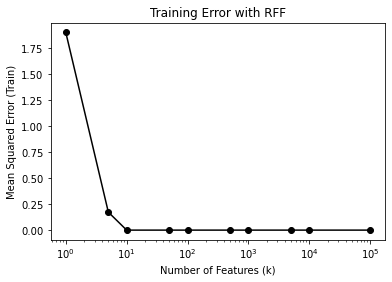

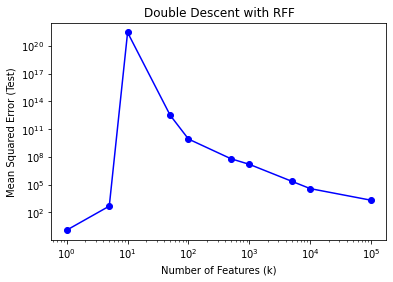

In [25]:
from numpy.linalg import pinv
SEED = 2134
np.random.seed(SEED)


def RFF(X, k=100):
    d, n = X.shape
    V = np.random.randn(k, d)
    rff = 1/np.sqrt(k) * np.exp(1j * V @ X)
    return rff


# Vary the number of RFF used for regression
num_features = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000, 100000]
train_errors = []
test_errors = []

for num_feat in num_features: 
    # Compute RFF for train & test data
    phi_X = RFF(X, k=num_feat)
    phi_X_test = RFF(X_test, k=num_feat)
            
    # Solve linear regression on RFF
    w_hat = y @ pinv(phi_X)
    preds = w_hat @ phi_X_test

    # Compute MSE for test samples
    test_error = np.mean(np.abs(np.power(preds - y_test, 2)))
    test_errors.append(test_error)
    
    train_error = np.mean(np.abs(np.power(w_hat @ phi_X - y, 2)))
    if np.isclose(train_error, 0): 
        train_error = 0
    train_errors.append(train_error)
    print(num_feat, train_error, error)

    
plt.plot(num_features, train_errors, 'ko-')
plt.title("Training Error with RFF")
plt.xscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Train)")
plt.show()

plt.plot(num_features, test_errors, 'bo-')
plt.title("Double Descent with RFF")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Features (k)")
plt.ylabel("Mean Squared Error (Test)")
plt.show()    

We make the following observations from the above figure: 

1. The test error peaks when using 10 features (e.g. the number of features = the number of training samples).  This is not coincidental, we can actually prove that the error goes to infinity even for over-parameterized linear regression. 

2. The test error decreases when using greater than 10 features.  

Observation 2 above begs the questions: What happens as we increase the number of features to infinity? We now analyze this case in the following section.

## RFF with Infinitely Many Features

We will now show that using infinitely many RFF above (i.e. $k \to \infty$) is equivalent to solving kernel regression with the Gaussian kernel (aka the Radial Basis Function kernel).  To find the kernel for RFF